# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [95]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader

    

In [96]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

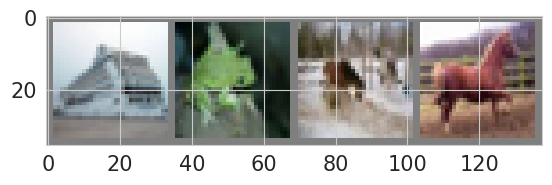

ship frog horse horse


In [35]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [37]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            # https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'), # using padding that heigth and weigth don't change
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32)
        )
        self.add_conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, padding='same')
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8),
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=512, out_features=10)
        )
        

    def forward(self, x):
        
        out = self.encoder(x)
        out += self.add_conv(x)
        out = self.head(out)
        
        return out

In [48]:
net = BasicBlockNet()
net

BasicBlockNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (add_conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (head): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [39]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [49]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [50]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data = data.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(data)
            loss = F.cross_entropy(logits, target)
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item()) 

    return np.mean(loss_log), np.mean(acc_log)

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [51]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4729463268459606, train acc: 0.47081075355383334
 val loss: 1.295005399369179, val acc: 0.54375

Epoch 1
 train loss: 1.182443222027592, train acc: 0.584523537477148
 val loss: 1.1243672690492996, val acc: 0.6067597518575952

Epoch 2
 train loss: 1.0579750299235802, train acc: 0.6315495234520824
 val loss: 1.0443156244906973, val acc: 0.6382535461415636

Epoch 3
 train loss: 0.9931123261042007, train acc: 0.6561520632485803
 val loss: 0.9848291815595424, val acc: 0.6575576241980208

Epoch 4
 train loss: 0.9523659032485167, train acc: 0.6720015017598377
 val loss: 1.018681011301406, val acc: 0.6464539007937654

Epoch 5
 train loss: 0.9292150225892145, train acc: 0.6764576260742802
 val loss: 0.9574096225677653, val acc: 0.6705008866939138

Epoch 6
 train loss: 0.901660232700857, train acc: 0.6876999544051273
 val loss: 0.9502074738766285, val acc: 0.6735150710065314

Epoch 7
 train loss: 0.8763892388539951, train acc: 0.6960857926818527
 val loss: 0.96687015979848

Посчитайте точность на тестовой выборке:

In [52]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.8549607149354971, accuracy = 0.706906847133758


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

Зная размер батча, посчитаем размер каждой эпохи и возьмём среднее

In [53]:
def plot_losses(train_loss, train_acc, val_loss_log, val_acc_log):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(train_loss) + 1), train_loss, label='train')
    axs[0].plot(range(1, len(val_loss_log) + 1), val_loss_log, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_acc) + 1), train_acc, label='train')
    axs[1].plot(range(1, len(val_acc_log) + 1), val_acc_log, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

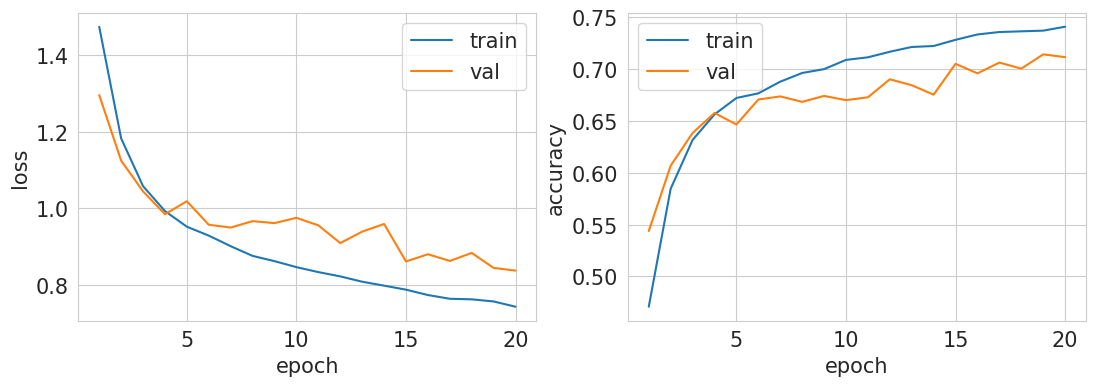

In [54]:
plot_losses(train_loss_log, train_acc_log, val_loss_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [55]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5124508844215212, train acc: 0.4614577892711437
 val loss: 1.3071845419863437, val acc: 0.540048758907521

Epoch 1
 train loss: 1.1847263393715923, train acc: 0.5837482045076011
 val loss: 1.1449636274195731, val acc: 0.5962544327086591

Epoch 2
 train loss: 1.0604426312708113, train acc: 0.6256202664192242
 val loss: 1.0310094782646666, val acc: 0.6416445035883721

Epoch 3
 train loss: 0.9968437509955175, train acc: 0.650969574394784
 val loss: 1.0590076197969152, val acc: 0.6330452127659575

Epoch 4
 train loss: 0.9615794763486608, train acc: 0.6658355641626571
 val loss: 0.984156866022881, val acc: 0.6560283688788718

Epoch 5
 train loss: 0.9304708154153563, train acc: 0.6761638157110545
 val loss: 0.9776690703757266, val acc: 0.66225620584285

Epoch 6
 train loss: 0.9152648771484766, train acc: 0.6804811962125942
 val loss: 1.001868514811739, val acc: 0.659375

Epoch 7
 train loss: 0.892899775962725, train acc: 0.6917072016970549
 val loss: 0.978544763554918,

Посчитайте точность на тестовой выборке:

In [56]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.841069037937055, accuracy = 0.7120820063694268


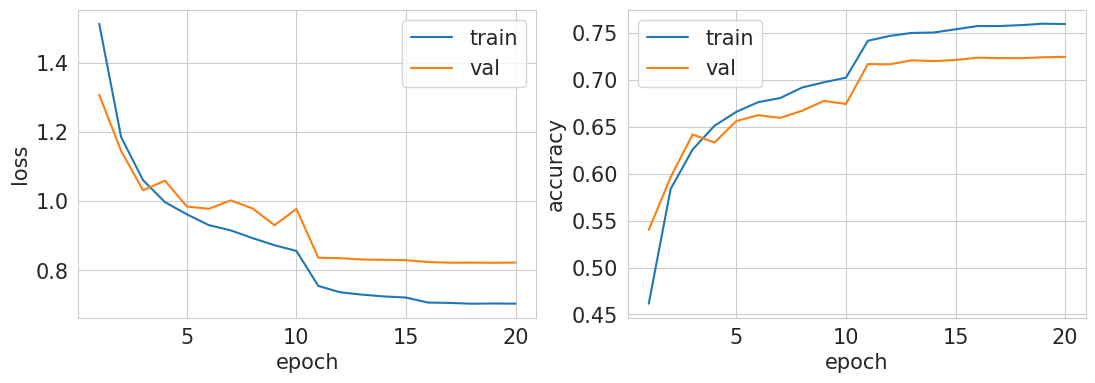

In [57]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [58]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.831293813489255, train acc: 0.3618356620916719
 val loss: 1.6049341607601084, val acc: 0.4449689716734785

Epoch 1
 train loss: 1.5199679343312489, train acc: 0.467701260197969
 val loss: 1.4433833933891134, val acc: 0.48854166675121224

Epoch 2
 train loss: 1.3996291840534105, train acc: 0.5087326978634654
 val loss: 1.357029197063852, val acc: 0.5235815603682336

Epoch 3
 train loss: 1.3248691982717358, train acc: 0.5343880582553159
 val loss: 1.294421227434848, val acc: 0.5448803191489362

Epoch 4
 train loss: 1.2676185322636007, train acc: 0.5538448354661791
 val loss: 1.2357745720985087, val acc: 0.5648049646235527

Epoch 5
 train loss: 1.2253451699312687, train acc: 0.5667847349177331
 val loss: 1.2262058169283765, val acc: 0.5664893617021277

Epoch 6
 train loss: 1.1854766254233269, train acc: 0.5853764037763397
 val loss: 1.2114598819550046, val acc: 0.5731382978723404

Epoch 7
 train loss: 1.1539591499612798, train acc: 0.5958923674588665
 val loss: 1.14

In [59]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.9526388611003851, accuracy = 0.6664012738853503


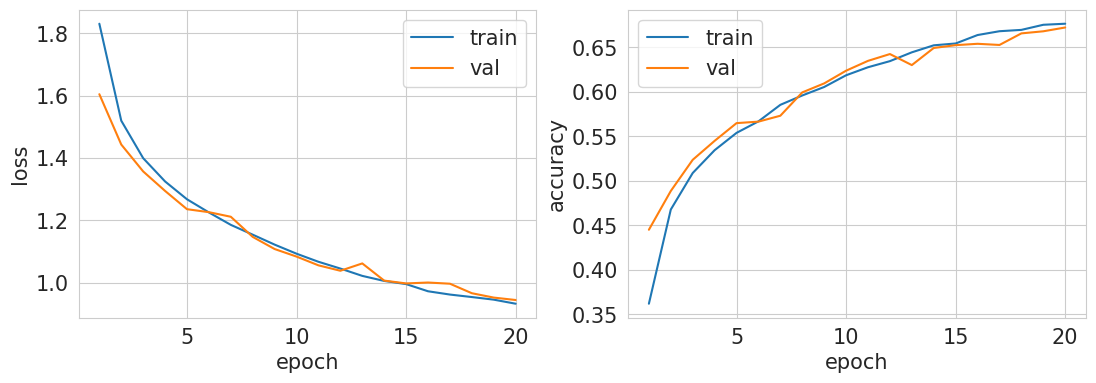

In [60]:
plot_losses(train_loss_log, train_acc_log, val_loss_log, val_acc_log)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

## ConstantLR

Работает следующим образом: `lr` делится на `factor` каждые `total_iters` эпох

In [61]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=0.5, total_iters=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4940062694837233, train acc: 0.4657914926190699
 val loss: 1.2559372422542978, val acc: 0.552016844013904

Epoch 1
 train loss: 1.1793084033446513, train acc: 0.5840012079183101
 val loss: 1.0929864508040408, val acc: 0.618971631374765

Epoch 2
 train loss: 1.0500891744763585, train acc: 0.6320636916422103
 val loss: 1.0436255531108125, val acc: 0.6313829787234042

Epoch 3
 train loss: 0.9900210450728589, train acc: 0.6555848459439042
 val loss: 1.0298797249794007, val acc: 0.6500886526513607

Epoch 4
 train loss: 0.9527281954257972, train acc: 0.6706303865861631
 val loss: 0.9745516596956456, val acc: 0.6662455675449778

Epoch 5
 train loss: 0.9223475949855784, train acc: 0.6801465787878856
 val loss: 0.9342956121931685, val acc: 0.6802526595744681

Epoch 6
 train loss: 0.8985403041734992, train acc: 0.6876060982290961
 val loss: 0.9171668572628752, val acc: 0.6858156029214251

Epoch 7
 train loss: 0.8848462417531057, train acc: 0.691213436928702
 val loss: 0.99

In [62]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.8972164904995329, accuracy = 0.6990445859872612


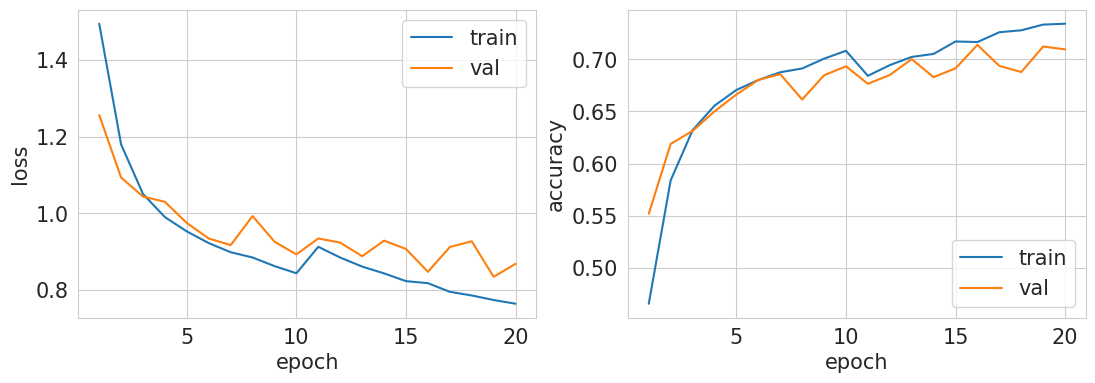

In [63]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

## PolynomialLR

Работает следующим образом: при дефолтном `power` равномерно уменьшает `lr` до доcтижения `total_iters`

In [64]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.503260920100064, train acc: 0.4631920867689785
 val loss: 1.3669366182164944, val acc: 0.5164450355032657

Epoch 1
 train loss: 1.2081908525888838, train acc: 0.5759907940188099
 val loss: 1.1471395900908936, val acc: 0.5984264186088075

Epoch 2
 train loss: 1.0872457688861616, train acc: 0.6194135218695269
 val loss: 1.1338711360667615, val acc: 0.6160682624958931

Epoch 3
 train loss: 1.0202392959725486, train acc: 0.6439181249146052
 val loss: 1.0091880377302778, val acc: 0.654188829787234

Epoch 4
 train loss: 0.9729041615177552, train acc: 0.6629953970638882
 val loss: 0.9668839436896304, val acc: 0.667065602921425

Epoch 5
 train loss: 0.9387584436528208, train acc: 0.6738786237549302
 val loss: 0.9559344076095744, val acc: 0.6684618795171697

Epoch 6
 train loss: 0.9100017972576553, train acc: 0.6820196200986232
 val loss: 0.9324958436032559, val acc: 0.6813608156873825

Epoch 7
 train loss: 0.8905571452878293, train acc: 0.6904340232748
 val loss: 0.96507

In [65]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.8335558637312264, accuracy = 0.7145700636942676


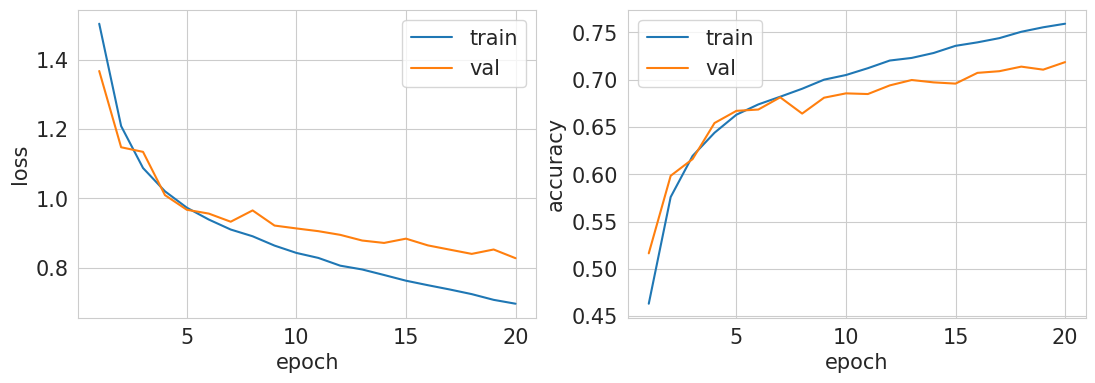

In [66]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

## OneCycleLR

Работает следующим образом: `lr` повышает до `max_lr`, далее уменьшает. Но лучше читать [тут](https://arxiv.org/abs/1708.07120)

In [68]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5390218544267866, train acc: 0.4485342126659763
 val loss: 1.3396062566878948, val acc: 0.5237145390916378

Epoch 1
 train loss: 1.260665574283007, train acc: 0.5534163619744058
 val loss: 1.2093847886044928, val acc: 0.575908688027808

Epoch 2
 train loss: 1.1427803232421387, train acc: 0.5981734787306359
 val loss: 1.1214979623226409, val acc: 0.6021054965384462

Epoch 3
 train loss: 1.0586495495365569, train acc: 0.6285706124314442
 val loss: 1.0363161949401205, val acc: 0.6406028369639782

Epoch 4
 train loss: 1.0022909701197413, train acc: 0.648819045458241
 val loss: 1.019246637060287, val acc: 0.6410017731341909

Epoch 5
 train loss: 0.9577362551549671, train acc: 0.6677738966410077
 val loss: 0.9824689375593307, val acc: 0.6566710993330529

Epoch 6
 train loss: 0.9324766236205859, train acc: 0.6761760577641196
 val loss: 0.9582600377975626, val acc: 0.6671099292471053

Epoch 7
 train loss: 0.9126752909184374, train acc: 0.681966570984075
 val loss: 1.0029

In [71]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.8275541518903842, accuracy = 0.7194466560509554


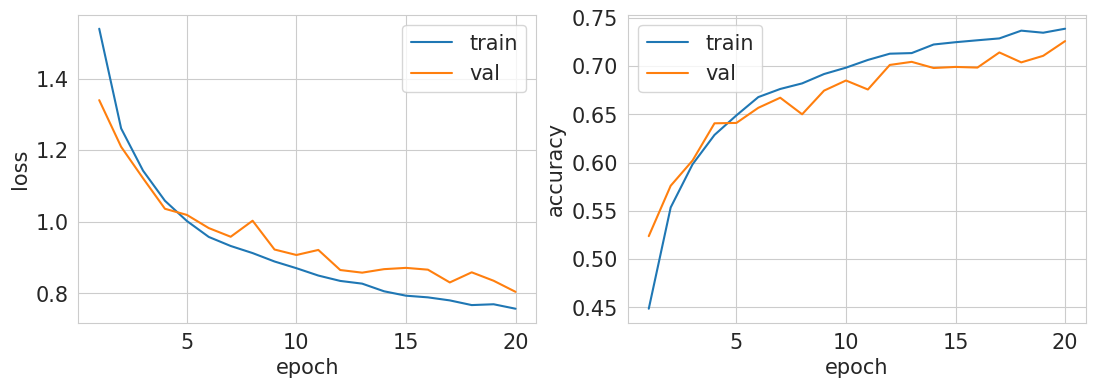

In [72]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

**Ответ:** Используя OneCycleLR смогли улучшить ошибку, но не прям сильно. Думаю, что надо повысить количество эпох, потому что в статье уже при 100 эпохах получили 86.7 ± 0.6

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

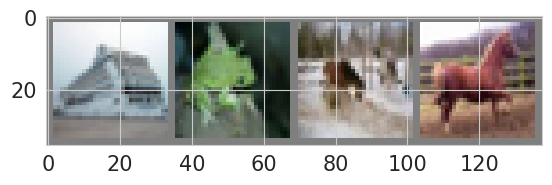

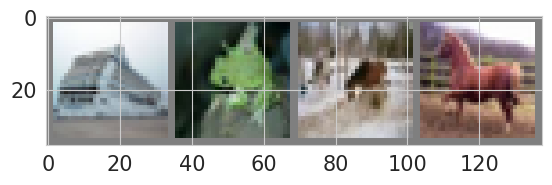

In [97]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [84]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4831858991051068, train acc: 0.47129635684450977
 val loss: 1.3186398024254657, val acc: 0.529033688027808

Epoch 1
 train loss: 1.1813000865566665, train acc: 0.5854457757372743
 val loss: 1.1320503957728123, val acc: 0.6048758866939139

Epoch 2
 train loss: 1.0581328426462204, train acc: 0.6303946853119887
 val loss: 1.0792725504712855, val acc: 0.6292996454746165

Epoch 3
 train loss: 0.9922978461769425, train acc: 0.6535159311303272
 val loss: 0.9912456456651079, val acc: 0.6566046100981692

Epoch 4
 train loss: 0.9560001497948627, train acc: 0.6664721533193013
 val loss: 0.985565468098255, val acc: 0.6537455675449777

Epoch 5
 train loss: 0.916978050084611, train acc: 0.6807586837294333
 val loss: 0.9458481162152392, val acc: 0.6687056739279564

Epoch 6
 train loss: 0.9011210019562319, train acc: 0.6907972055989602
 val loss: 0.941158874237791, val acc: 0.6705895390916378

Epoch 7
 t

Посчитайте точность на тестовой выборке:

In [85]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.79208581861417, accuracy = 0.7299960191082803


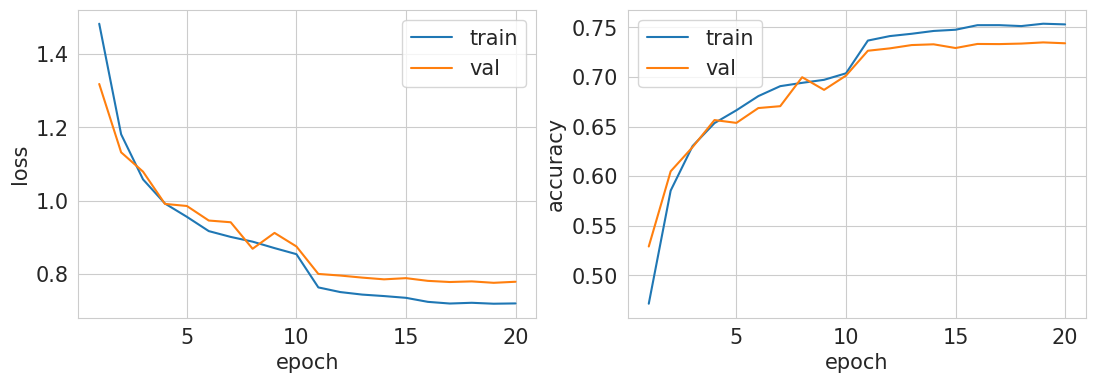

In [86]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

## RandomRotation

Поворачивает картинку на нужный угол

In [98]:
transform = transforms.Compose(
        [transforms.RandomRotation(degrees=(0, 180)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7953485677621481, train acc: 0.35590232442894193
 val loss: 1.6824031292123998, val acc: 0.3993572695458189

Epoch 1
 train loss: 1.6215241162389027, train acc: 0.42356849049083495
 val loss: 1.5332155334188584, val acc: 0.4504432624958931

Epoch 2
 train loss: 1.5338620551107571, train acc: 0.45416557854228745
 val loss: 1.5099591316060816, val acc: 0.4672650710065314

Epoch 3
 train loss: 1.4798205428411146, train acc: 0.4755525268627913
 val loss: 1.4861380358959766, val acc: 0.47679521276595743

Epoch 4
 train loss: 1.4294381958910927, train acc: 0.4916998564216293
 val loss: 1.4287404268345933, val acc: 0.4996897163543295

Epoch 5
 train loss: 1.405208661961599, train acc: 0.4993470880514525
 val loss: 1.4006770656463947, val acc: 0.5062943263256804

Epoch 6
 train loss: 1.3749387158554258, train acc: 0.514588502251034
 val loss: 1.3467692633892627, val acc: 0.5277260638297873

Epoch

In [99]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 1.397247183095118, accuracy = 0.5061703821656051


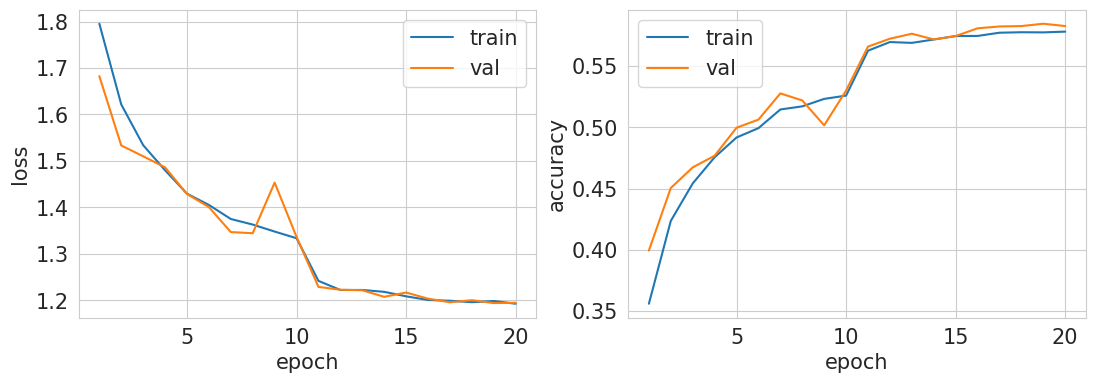

In [100]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

## RandomSolarize

С определённой вероятностью инвертирует все пиксели, у которых значения выше `threshold`

In [101]:
transform = transforms.Compose(
        [transforms.RandomSolarize(threshold=1.0),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7194685051166598, train acc: 0.3914941891455781
 val loss: 1.4744269041304892, val acc: 0.47976507100653143

Epoch 1
 train loss: 1.3835362245003529, train acc: 0.5202525137111518
 val loss: 1.3424994164324822, val acc: 0.5376773050490846

Epoch 2
 train loss: 1.260031792646788, train acc: 0.5652871180931872
 val loss: 1.2100439155355414, val acc: 0.5856161348363187

Epoch 3
 train loss: 1.1922293336997303, train acc: 0.5944355575868373
 val loss: 1.1949293265951442, val acc: 0.5917774824385947

Epoch 4
 train loss: 1.1562893770948406, train acc: 0.6030091082156249
 val loss: 1.2227205662017173, val acc: 0.5810505319148936

Epoch 5
 train loss: 1.1249984673869675, train acc: 0.6138515278451839
 val loss: 1.1492831856646437, val acc: 0.6037898936170213

Epoch 6
 train loss: 1.0982761486574761, train acc: 0.6229514887171645
 val loss: 1.089752421480544, val acc: 0.6292331561129144

Epoch 7


In [102]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.9454963442626273, accuracy = 0.6755573248407644


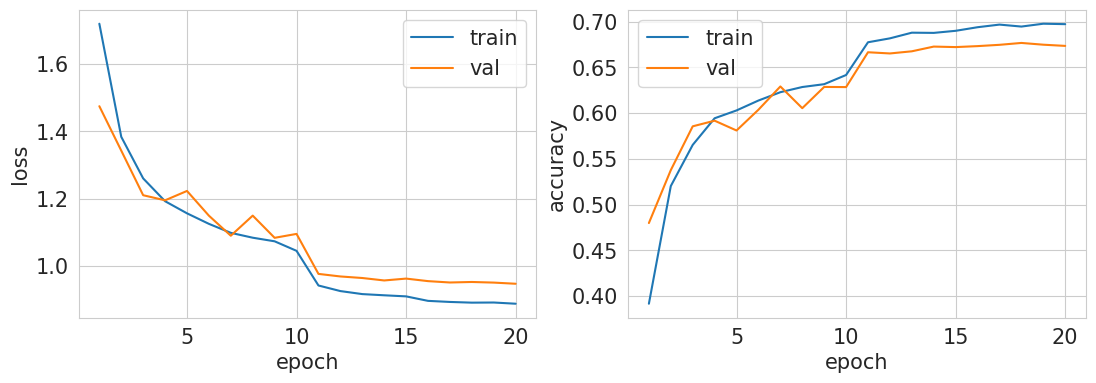

In [103]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

## GaussianBlur

Блюрит пиксели с данными параметрами. Если `sigma` это тупл, то `sigma` выбирается равномерно из отрезка

In [104]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 5.)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5598862190787055, train acc: 0.4442576391169532
 val loss: 1.4028504031769773, val acc: 0.4987145390916378

Epoch 1
 train loss: 1.3069632172148669, train acc: 0.5386809546507255
 val loss: 1.2082131403557799, val acc: 0.5741356382978723

Epoch 2
 train loss: 1.213417208063973, train acc: 0.5740687842778793
 val loss: 1.1630585452343556, val acc: 0.5952570922831272

Epoch 3
 train loss: 1.1537105478142036, train acc: 0.595606718464351
 val loss: 1.1129743144867268, val acc: 0.6133865249917863

Epoch 4
 train loss: 1.1074105275614388, train acc: 0.6142065488006341
 val loss: 1.1122280519059364, val acc: 0.6100620569066798

Epoch 5
 train loss: 1.075422699534261, train acc: 0.6231187974295189
 val loss: 1.0990299250217195, val acc: 0.6138741135597229

Epoch 6
 train loss: 1.0474796797501322, train acc: 0.6363117001828154
 val loss: 1.0916922805157114, val acc: 0.6178191489361702

Epoch 7
 t

In [105]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 1.0277205747403917, accuracy = 0.6640127388535032


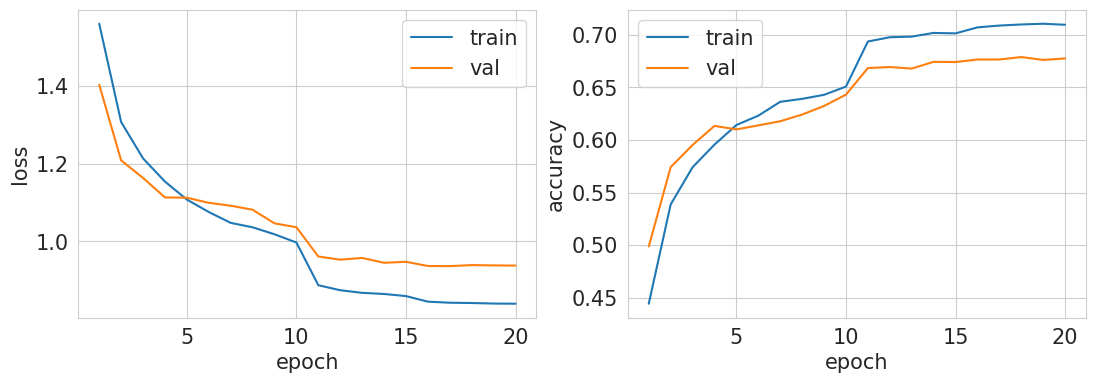

In [106]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

## RandomHorizontalFlip x GaussianBlur x RandomSolarize x RandomRotation

In [107]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomApply(transforms=[
             transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 5.)),
             transforms.RandomSolarize(threshold=1.0)
         ]),
         transforms.RandomRotation(degrees=(0, 180)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 2.0260155719638524, train acc: 0.26923233875408903
 val loss: 1.929051329227204, val acc: 0.31063829787234043

Epoch 1
 train loss: 1.8701784216289765, train acc: 0.33223018415231376
 val loss: 1.8216904036542203, val acc: 0.3553634752618506

Epoch 2
 train loss: 1.7996893083809498, train acc: 0.3605910486233518
 val loss: 1.7610808575406987, val acc: 0.37604166675121226

Epoch 3
 train loss: 1.756112150126009, train acc: 0.37756267958192985
 val loss: 1.705999095896457, val acc: 0.39609929082241463

Epoch 4
 train loss: 1.7203868675493452, train acc: 0.38839285715842375
 val loss: 1.7568318686586746, val acc: 0.385815602921425

Epoch 5
 train loss: 1.6984947616918866, train acc: 0.3977662249173717
 val loss: 1.7345713635708424, val acc: 0.38818705677986143

Epoch 6
 train loss: 1.6841152102245491, train acc: 0.40421373077022965
 val loss: 1.6455952142147308, val acc: 0.4139627659574468

Ep

In [108]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 1.5581621971859294, accuracy = 0.44804936305732485


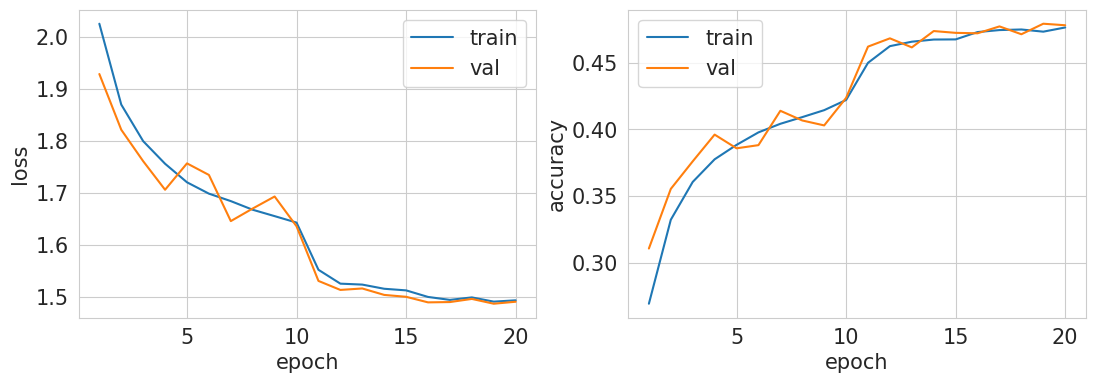

In [109]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

**Ответ:** Из всех рассмотренных аугментаций качество удалось улучшить лишь с помощью RandomHorizontalFlip. При других аугментациях похоже задача становится слишком сложной и 20 эпох не достаточно. Возможно они показали бы себя лучше, если качество картинок было повыше

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [110]:
!pip install wandb

In [111]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [112]:
wandb.init(
    project="my-awesome-cnn",
    config={
    "learning_rate": 0.1,
    "architecture": "CNN",
    "dataset": "CIFAR-10",
    "epochs": 20,
    })

wandb: Currently logged in as: free001style (free001). Use `wandb login --relogin` to force relogin


In [114]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        wandb.log({'train loss':train_loss, 'train acc':train_acc, 'val loss':val_loss, 'val acc':val_acc})

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [116]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)
wandb.finish()

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4885167495860043, train acc: 0.4676114848152593
 val loss: 1.3038550095355257, val acc: 0.5341976950777337

Epoch 1
 train loss: 1.1958814835417642, train acc: 0.5788023962181272
 val loss: 1.1280431600327188, val acc: 0.6049202127659574

Epoch 2
 train loss: 1.0647325158337135, train acc: 0.6268077501431244
 val loss: 1.0884105365327064, val acc: 0.6265514186088075

Epoch 3
 train loss: 1.0013551724022443, train acc: 0.6524345456355233
 val loss: 0.9901147555797658, val acc: 0.658222517815042

Epoch 4
 train loss: 0.9635731172518059, train acc: 0.6663619744058501
 val loss: 0.9987913694787532, val acc: 0.6492021276595744

Epoch 5
 train loss: 0.9281205035868685, train acc: 0.678269456792793
 val loss: 0.9538719405519201, val acc: 0.6679299646235527

Epoch 6
 train loss: 0.9121028277512224, train acc: 0.688050894567256
 val loss: 0.9855178280079618, val acc: 0.6559397164811479

Epoch 7
 t

train acc,▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▆▆▇▇▇▇▇▇▇██████████
train loss,█▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val acc,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▆▆▇▇▇▇▇▇▇██████████
val loss,█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train acc,0.74984
train loss,0.72523
val acc,0.73172
val loss,0.78419


графики [тут](https://wandb.ai/free001/my-awesome-cnn/runs/vng1x6vd?workspace=user-free001style)